In this notebook, we consider a ZDT1 problem with Gaussian noise, and benckmark two "denoising" methods:
* a naive average method,
* the KNN-Avg algorithm.

In [1]:
import nmoo

The first step is to construct our problem pipelines. We start with a `ZDT1` instance, that we wrap in a `ProblemWrapper`. In nmoo, `ProblemWrapper` is the base class to modify problems, in our case adding and removing noise. Additionally, `ProblemWrapper` and classes deriving from it maintain a history of every call made to their `_evaluate` method (see the [pymoo documentation](https://pymoo.org/getting_started.html#By-Class)).

Next, we add a Gaussian noise of type `N(0, 0.25)` and the averaging algorithm.

In [2]:
from pymoo.problems.multi import ZDT1
import numpy as np

zdt1 = ZDT1()
wrapped_zdt1_1 = nmoo.WrappedProblem(zdt1)
mean = np.array([0, 0])
covariance = np.array([[1., -.5], [-.5, 1]])
noisy_zdt1_1 = nmoo.noises.GaussianNoise(
    wrapped_zdt1_1, 
    {"F": (mean, covariance)},
)
avg_zdt1 = nmoo.denoisers.ResampleAverage(noisy_zdt1_1, n_evaluations=10)

We construct a similar pipeline for the KNN-Avg algorithm. Note that although we can reuse the same pymoo `Problem` instance (in this case, `zdt1`), it is advised to create a new wrapped problem and a new noisy problem, since nmoo `ProblemWrapper` is stateful.

In [3]:

wrapped_zdt1_2 = nmoo.WrappedProblem(zdt1)
noisy_zdt1_2 = nmoo.noises.GaussianNoise(
    wrapped_zdt1_2, 
    {"F": (mean, covariance)},
)
knnavg_zdt1 = nmoo.denoisers.KNNAvg(
    noisy_zdt1_2,
    distance_weight_type="squared",
    max_distance=1.0,
    n_neighbors=100,
)

Now, we setup an algorithm that will try and solve our `avg_zdt1` and `knnavg_zdt1` problems.

In [4]:
from pymoo.algorithms.nsga2 import NSGA2

nsga2 = NSGA2(
    pop_size=40,
    n_offsprings=10,
    eliminate_duplicates=True,
)

Finally, we setup our benchmark. It will run NSGA2 against `avg_zdt1` and `knnavg_zdt1` five times each. Additionally, we specify a Pareto front population to measure the performance, not of NSGA2, but of KNN-Avg against the averaging method.

In [5]:
import os

from pymoo.factory import get_termination

OUT_PATH = "./out"
if not os.path.isdir(OUT_PATH):
    os.mkdir(OUT_PATH)

pareto_front = zdt1.pareto_front(100)

benchmark = nmoo.benchmark.Benchmark(
    output_dir_path=OUT_PATH,
    problems={
        "knnavg": {
            "problem": knnavg_zdt1,
            "pareto_front": pareto_front,
        },
        "avg": {
            "problem": avg_zdt1,
            "pareto_front": pareto_front,
        },
    },
    algorithms={
        "nsga2": {
            "algorithm": nsga2,
        },
        "nsga2_10": {
            "algorithm": nsga2,
            "termination": get_termination("n_gen", 10),
        },
        "nsga2_100": {
            "algorithm": nsga2,
            "termination": get_termination("n_gen", 100),
        },
    },
    n_runs=5,
)

In [6]:
%%time
benchmark.run(verbose=50)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

Results of the benchmark are automatically saved:

In [7]:
! ls -l ./out

total 66512
-rw-r--r--  1 cedric  staff   757730 Jun 14 11:43 avg.nsga2.1.1.npz
-rw-r--r--  1 cedric  staff  2593967 Jun 14 11:43 avg.nsga2.1.2.npz
-rw-r--r--  1 cedric  staff  1068746 Jun 14 11:43 avg.nsga2.1.3.npz
-rw-r--r--  1 cedric  staff   295730 Jun 14 11:41 avg.nsga2.2.1.npz
-rw-r--r--  1 cedric  staff  1007502 Jun 14 11:41 avg.nsga2.2.2.npz
-rw-r--r--  1 cedric  staff   409607 Jun 14 11:41 avg.nsga2.2.3.npz
-rw-r--r--  1 cedric  staff   307695 Jun 14 11:41 avg.nsga2.3.1.npz
-rw-r--r--  1 cedric  staff  1043964 Jun 14 11:41 avg.nsga2.3.2.npz
-rw-r--r--  1 cedric  staff   431039 Jun 14 11:41 avg.nsga2.3.3.npz
-rw-r--r--  1 cedric  staff   579194 Jun 14 11:42 avg.nsga2.4.1.npz
-rw-r--r--  1 cedric  staff  1965872 Jun 14 11:42 avg.nsga2.4.2.npz
-rw-r--r--  1 cedric  staff   817289 Jun 14 11:42 avg.nsga2.4.3.npz
-rw-r--r--  1 cedric  staff   669774 Jun 14 11:43 avg.nsga2.5.1.npz
-rw-r--r--  1 cedric  staff  2289108 Jun 14 11:43 avg.nsga2.5.2.npz
-rw-r--r--  1 cedric  staff   940468

The benchmark results are saved in `benchmark.csv`. They can also be accessed by `benchmark._results`. The rest are problem call histories, named after the following scheme:
```
<problem_name>.<algorithm_name>.<n_run>.<level>.npz
```
For example, `knnavg.nsga2_100.3.2.npz` is the `GaussianNoise` history (level 2) of the 3rd run of `NSGA2` (100 generations) on the `knnavg` pipeline.

Let's now visualize the results. The final result of all runs can be found using the `Benchmark.final_results` method:

In [8]:
benchmark.final_results()

,algorithm,problem,n_run,n_gen,timedelta,perf_gd,perf_gd+,perf_igd,perf_igd+
0,nsga2,avg,1,515,799270,0.859081,0.800055,0.217689,0.217126
1,nsga2,avg,2,200,267547,0.895126,0.847959,0.269108,0.257674
2,nsga2,avg,3,205,347869,1.010306,0.976278,0.393678,0.392786
3,nsga2,avg,4,387,119446,0.781774,0.741961,0.252349,0.244607
4,nsga2,avg,5,455,754429,0.840899,0.791859,0.274992,0.274841
5,nsga2,knnavg,1,340,993456,1.602175,1.146168,0.307697,0.009203
6,nsga2,knnavg,2,240,314843,2.079609,1.736191,0.144020,0.111763
7,nsga2,knnavg,3,320,246753,1.806879,1.375361,0.164115,0.026811
8,nsga2,knnavg,4,195,540132,2.300057,1.905633,0.346313,0.307999
9,nsga2,knnavg,5,390,39678,2.114616,1.608997,0.235631,0.000000


The following boxplot indicates that, with the same number of calls to `ZDT1`, KNN-Avg offers a better GD+ performance. However, on the number of generation is fixed or unconstrained, then the averaging method is better.

<AxesSubplot:xlabel='problem', ylabel='perf_gd+'>

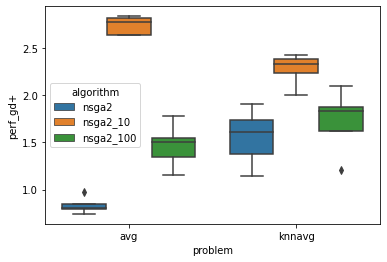

In [9]:
import seaborn as sns

sns.boxplot(
    x="problem", 
    y="perf_gd+", 
    hue="algorithm",
    data=benchmark.final_results(),
)

The following boxplot depicts the runtimes.

<AxesSubplot:xlabel='problem', ylabel='timedelta'>

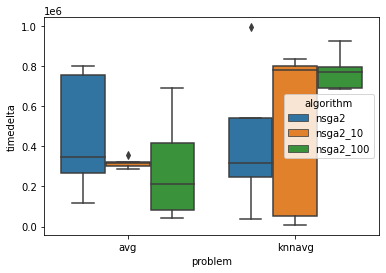

In [10]:
sns.boxplot(
    x="problem", 
    y="timedelta", 
    hue="algorithm",
    data=benchmark.final_results(),
)